### Cab-Driver Agent

In [26]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [27]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [28]:
Time_matrix[1][2][3]

array([5., 6., 5., 7., 7., 9., 7.])

In [29]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


#### Tracking the state-action pairs for checking convergence


In [30]:
def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [31]:
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [32]:
def initialise_tracking_states(): 
    samvalues = [((3,0,2),(3,1)),((1,6,3),(2,3)),((2,2,2),(3,2))] 
    #select any 4 Q-values 
    for q_value in samvalues: 
        state = Q_state(q_value[0]) 
        action = q_value[1] 
        states_track[state][action] = []

In [33]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [34]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [35]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01       
        self.epsilon_max = 1
        self.epsilon_decay =0.99 
        self.epsilon_min = 0.01
        self.states_tracked = []
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state):
    # Write your code here:        
        poss_index, actions = env.requests(state)        
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        if np.random.rand() <= self.epsilon_max:
            # explore: choose a random action from all possible actions            
            action = random.choice(actions)
            return action
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state_encode = env.state_encod_arch1(state)
            state_batch = state_encode.reshape(1, self.state_size)
            q_value = self.model.predict(state_batch)
            self.states_tracked.append(q_value[0][2])
            qvalue = [q_value[0][index] for index in poss_index]
            #print("poss_index", poss_index, " actions ", actions, " state ",state)
            if not poss_index:
                return actions[0]
            else:
                index = np.argmax(qvalue)            
                return actions[index]     
     
        
    def append_sample(self, state, action, reward, next_state, done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, terminals = [], [],[]
            
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                terminals.append(terminal)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
             
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):                
                if terminals[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0) 

    def save(self, name):
        self.model.save(name) 

In [36]:
Episodes = 10000

### DQN block

In [37]:
#  environment
env = CabDriver()

# get size of state and action from environment
state_size = len(env.state_space[0])  # equal to 4 in case of cartpole 
action_size = len(env.action_space)   # equal to 2 in case of cartpole



In [38]:


# agent needs to be initialised outside the loop since the DQN
# network will be initialised along with the agent
agent = DQNAgent(action_size=action_size, state_size=state_size)
score_tracked = []
state = []


# to store rewards in each episode
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here   
    # Call the environment   
    # Call all the initialised variables of the environment
    score = 0 
    action_space, state_space, state = env.reset()
    terminal_state = False
    #Call the DQN agent
    print(state)
        
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        # populate update_input and update_output and the lists rewards, actions, done
       
        # get action for the current state and take a step in the environment
        action = agent.get_action(state)       
        reward = env.reward_func(state, action, Time_matrix) 
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)
        
        # save the sample <s, a, r, s', terminal_state> to the replay memory
        agent.append_sample(state, action, reward, next_state, terminal_state)

        # train after each step
        agent.train_model()

        # add reward to the total score of this episode
        score += reward
        state = next_state


    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    if agent.epsilon_max > agent.epsilon_min:
        agent.epsilon_max *= agent.epsilon_decay

    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon_max))
    # Total rewards per episode
    
    score_tracked.append(score)
    
    # every few episodes:
    if episode % 100 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()
        # save model weights
        save_tracking_states() 
        save_obj(States_track,'States_tracked') 
        agent.save(name="CarPol_model.h5")
        
        

[0, 13, 5]
episode 0, reward 2854.0, memory_length 169, epsilon 0.99
[0, 13, 5]
episode 1, reward 3061.0, memory_length 295, epsilon 0.9801
[0, 13, 5]
episode 2, reward 3013.0, memory_length 435, epsilon 0.9702989999999999
[0, 13, 5]
episode 3, reward 2864.0, memory_length 572, epsilon 0.96059601
[0, 13, 5]
episode 4, reward 2932.0, memory_length 722, epsilon 0.9509900498999999
[0, 13, 5]
episode 5, reward 3007.0, memory_length 852, epsilon 0.9414801494009999
[0, 13, 5]
episode 6, reward 2875.0, memory_length 994, epsilon 0.9320653479069899
[0, 13, 5]
episode 7, reward 2865.0, memory_length 1151, epsilon 0.92274469442792
[0, 13, 5]
episode 8, reward 3100.0, memory_length 1285, epsilon 0.9135172474836407
[0, 13, 5]
episode 9, reward 2911.0, memory_length 1437, epsilon 0.9043820750088043
[0, 13, 5]
episode 10, reward 3036.0, memory_length 1572, epsilon 0.8953382542587163
[0, 13, 5]
episode 11, reward 2970.0, memory_length 1714, epsilon 0.8863848717161291
[0, 13, 5]
episode 12, reward 283

episode 97, reward 3102.0, memory_length 2000, epsilon 0.37346428045426927
[0, 13, 5]
episode 98, reward 3171.0, memory_length 2000, epsilon 0.36972963764972655
[0, 13, 5]
episode 99, reward 3129.0, memory_length 2000, epsilon 0.36603234127322926
[0, 13, 5]
episode 100, reward 3136.0, memory_length 2000, epsilon 0.36237201786049694
[0, 13, 5]
episode 101, reward 3067.0, memory_length 2000, epsilon 0.358748297681892
[0, 13, 5]
episode 102, reward 3015.0, memory_length 2000, epsilon 0.35516081470507305
[0, 13, 5]
episode 103, reward 3092.0, memory_length 2000, epsilon 0.3516092065580223
[0, 13, 5]
episode 104, reward 3145.0, memory_length 2000, epsilon 0.34809311449244207
[0, 13, 5]
episode 105, reward 3161.0, memory_length 2000, epsilon 0.34461218334751764
[0, 13, 5]
episode 106, reward 3074.0, memory_length 2000, epsilon 0.34116606151404244
[0, 13, 5]
episode 107, reward 3102.0, memory_length 2000, epsilon 0.337754400898902
[0, 13, 5]
episode 108, reward 3142.0, memory_length 2000, eps

episode 192, reward 3185.0, memory_length 2000, epsilon 0.14374493715362485
[0, 13, 5]
episode 193, reward 3196.0, memory_length 2000, epsilon 0.1423074877820886
[0, 13, 5]
episode 194, reward 3176.0, memory_length 2000, epsilon 0.1408844129042677
[0, 13, 5]
episode 195, reward 3198.0, memory_length 2000, epsilon 0.13947556877522502
[0, 13, 5]
episode 196, reward 3200.0, memory_length 2000, epsilon 0.13808081308747278
[0, 13, 5]
episode 197, reward 3175.0, memory_length 2000, epsilon 0.13670000495659804
[0, 13, 5]
episode 198, reward 3203.0, memory_length 2000, epsilon 0.13533300490703207
[0, 13, 5]
episode 199, reward 3133.0, memory_length 2000, epsilon 0.13397967485796175
[0, 13, 5]
episode 200, reward 3226.0, memory_length 2000, epsilon 0.13263987810938213
[0, 13, 5]
episode 201, reward 3174.0, memory_length 2000, epsilon 0.1313134793282883
[0, 13, 5]
episode 202, reward 3164.0, memory_length 2000, epsilon 0.13000034453500542
[0, 13, 5]
episode 203, reward 3187.0, memory_length 2000

episode 287, reward 3188.0, memory_length 2000, epsilon 0.055326862671220584
[0, 13, 5]
episode 288, reward 3173.0, memory_length 2000, epsilon 0.05477359404450838
[0, 13, 5]
episode 289, reward 3254.0, memory_length 2000, epsilon 0.054225858104063294
[0, 13, 5]
episode 290, reward 3259.0, memory_length 2000, epsilon 0.05368359952302266
[0, 13, 5]
episode 291, reward 3206.0, memory_length 2000, epsilon 0.053146763527792434
[0, 13, 5]
episode 292, reward 3203.0, memory_length 2000, epsilon 0.052615295892514506
[0, 13, 5]
episode 293, reward 3198.0, memory_length 2000, epsilon 0.052089142933589364
[0, 13, 5]
episode 294, reward 3210.0, memory_length 2000, epsilon 0.05156825150425347
[0, 13, 5]
episode 295, reward 3217.0, memory_length 2000, epsilon 0.051052568989210935
[0, 13, 5]
episode 296, reward 3206.0, memory_length 2000, epsilon 0.05054204329931883
[0, 13, 5]
episode 297, reward 3181.0, memory_length 2000, epsilon 0.05003662286632564
[0, 13, 5]
episode 298, reward 3169.0, memory_le

episode 381, reward 3228.0, memory_length 2000, epsilon 0.021510194444071803
[0, 13, 5]
episode 382, reward 3186.0, memory_length 2000, epsilon 0.021295092499631085
[0, 13, 5]
episode 383, reward 3219.0, memory_length 2000, epsilon 0.021082141574634772
[0, 13, 5]
episode 384, reward 3218.0, memory_length 2000, epsilon 0.020871320158888425
[0, 13, 5]
episode 385, reward 3187.0, memory_length 2000, epsilon 0.020662606957299542
[0, 13, 5]
episode 386, reward 3237.0, memory_length 2000, epsilon 0.020455980887726547
[0, 13, 5]
episode 387, reward 3218.0, memory_length 2000, epsilon 0.02025142107884928
[0, 13, 5]
episode 388, reward 3211.0, memory_length 2000, epsilon 0.020048906868060788
[0, 13, 5]
episode 389, reward 3198.0, memory_length 2000, epsilon 0.01984841779938018
[0, 13, 5]
episode 390, reward 3217.0, memory_length 2000, epsilon 0.019649933621386378
[0, 13, 5]
episode 391, reward 3202.0, memory_length 2000, epsilon 0.019453434285172513
[0, 13, 5]
episode 392, reward 3177.0, memory

episode 475, reward 3192.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 476, reward 3221.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 477, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 478, reward 3251.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 479, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 480, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 481, reward 3180.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 482, reward 3201.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 483, reward 3181.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 484, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 485, reward 3246.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 486, reward 3205.0, memo

episode 569, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 570, reward 3203.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 571, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 572, reward 3233.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 573, reward 3259.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 574, reward 3228.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 575, reward 3218.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 576, reward 3241.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 577, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 578, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 579, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 580, reward 3218.0, memo

episode 663, reward 3233.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 664, reward 3173.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 665, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 666, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 667, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 668, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 669, reward 3274.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 670, reward 3228.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 671, reward 3257.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 672, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 673, reward 3193.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 674, reward 3207.0, memo

episode 757, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 758, reward 3189.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 759, reward 3250.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 760, reward 3175.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 761, reward 3279.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 762, reward 3219.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 763, reward 3237.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 764, reward 3170.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 765, reward 3198.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 766, reward 3249.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 767, reward 3158.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 768, reward 3226.0, memo

episode 851, reward 3239.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 852, reward 3218.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 853, reward 3166.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 854, reward 3240.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 855, reward 3207.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 856, reward 3197.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 857, reward 3192.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 858, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 859, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 860, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 861, reward 3252.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 862, reward 3244.0, memo

episode 945, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 946, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 947, reward 3198.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 948, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 949, reward 3198.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 950, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 951, reward 3233.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 952, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 953, reward 3152.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 954, reward 3186.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 955, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 956, reward 3228.0, memo

episode 1038, reward 3265.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1039, reward 3280.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1040, reward 3235.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1041, reward 3238.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1042, reward 3228.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1043, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1044, reward 3213.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1045, reward 3240.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1046, reward 3259.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1047, reward 3187.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1048, reward 3231.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1049, reward 

episode 1131, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1132, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1133, reward 3237.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1134, reward 3207.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1135, reward 3206.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1136, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1137, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1138, reward 3206.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1139, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1140, reward 3190.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1141, reward 3259.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1142, reward 

episode 1224, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1225, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1226, reward 3161.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1227, reward 3181.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1228, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1229, reward 3268.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1230, reward 3228.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1231, reward 3182.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1232, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1233, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1234, reward 3231.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1235, reward 

episode 1317, reward 3211.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1318, reward 3204.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1319, reward 3256.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1320, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1321, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1322, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1323, reward 3270.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1324, reward 3187.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1325, reward 3238.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1326, reward 3249.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1327, reward 3218.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1328, reward 

episode 1410, reward 3264.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1411, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1412, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1413, reward 3250.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1414, reward 3203.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1415, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1416, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1417, reward 3221.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1418, reward 3203.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1419, reward 3177.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1420, reward 3231.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1421, reward 

episode 1503, reward 3185.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1504, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1505, reward 3242.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1506, reward 3278.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1507, reward 3193.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1508, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1509, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1510, reward 3189.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1511, reward 3257.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1512, reward 3257.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1513, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1514, reward 

episode 1596, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1597, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1598, reward 3235.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1599, reward 3207.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1600, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1601, reward 3178.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1602, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1603, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1604, reward 3231.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1605, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1606, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1607, reward 

episode 1689, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1690, reward 3249.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1691, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1692, reward 3203.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1693, reward 3219.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1694, reward 3240.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1695, reward 3231.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1696, reward 3194.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1697, reward 3190.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1698, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1699, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1700, reward 

episode 1782, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1783, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1784, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1785, reward 3195.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1786, reward 3250.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1787, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1788, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1789, reward 3197.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1790, reward 3207.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1791, reward 3258.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1792, reward 3237.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1793, reward 

episode 1875, reward 3198.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1876, reward 3253.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1877, reward 3181.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1878, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1879, reward 3247.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1880, reward 3228.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1881, reward 3242.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1882, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1883, reward 3205.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1884, reward 3255.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1885, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1886, reward 

episode 1968, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1969, reward 3248.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1970, reward 3203.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1971, reward 3235.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1972, reward 3247.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1973, reward 3218.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1974, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1975, reward 3151.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1976, reward 3242.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1977, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1978, reward 3193.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 1979, reward 

episode 2061, reward 3250.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2062, reward 3203.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2063, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2064, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2065, reward 3248.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2066, reward 3201.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2067, reward 3237.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2068, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2069, reward 3267.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2070, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2071, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2072, reward 

episode 2154, reward 3194.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2155, reward 3228.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2156, reward 3189.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2157, reward 3219.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2158, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2159, reward 3233.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2160, reward 3204.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2161, reward 3207.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2162, reward 3256.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2163, reward 3245.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2164, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2165, reward 

episode 2247, reward 3200.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2248, reward 3262.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2249, reward 3191.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2250, reward 3187.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2251, reward 3207.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2252, reward 3276.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2253, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2254, reward 3182.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2255, reward 3261.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2256, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2257, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2258, reward 

episode 2340, reward 3261.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2341, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2342, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2343, reward 3176.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2344, reward 3183.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2345, reward 3194.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2346, reward 3278.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2347, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2348, reward 3247.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2349, reward 3196.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2350, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2351, reward 

episode 2433, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2434, reward 3238.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2435, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2436, reward 3247.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2437, reward 3211.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2438, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2439, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2440, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2441, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2442, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2443, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2444, reward 

episode 2526, reward 3241.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2527, reward 3193.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2528, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2529, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2530, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2531, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2532, reward 3197.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2533, reward 3235.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2534, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2535, reward 3218.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2536, reward 3186.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2537, reward 

episode 2619, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2620, reward 3195.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2621, reward 3240.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2622, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2623, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2624, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2625, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2626, reward 3192.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2627, reward 3219.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2628, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2629, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2630, reward 

episode 2712, reward 3243.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2713, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2714, reward 3253.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2715, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2716, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2717, reward 3205.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2718, reward 3198.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2719, reward 3213.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2720, reward 3186.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2721, reward 3228.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2722, reward 3205.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2723, reward 

episode 2805, reward 3194.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2806, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2807, reward 3188.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2808, reward 3213.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2809, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2810, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2811, reward 3233.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2812, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2813, reward 3235.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2814, reward 3258.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2815, reward 3246.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2816, reward 

episode 2898, reward 3195.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2899, reward 3196.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2900, reward 3172.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2901, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2902, reward 3193.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2903, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2904, reward 3245.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2905, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2906, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2907, reward 3242.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2908, reward 3189.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2909, reward 

episode 2991, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2992, reward 3280.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2993, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2994, reward 3235.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2995, reward 3193.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2996, reward 3192.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2997, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2998, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 2999, reward 3175.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3000, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3001, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3002, reward 

episode 3084, reward 3240.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3085, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3086, reward 3218.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3087, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3088, reward 3219.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3089, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3090, reward 3184.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3091, reward 3237.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3092, reward 3193.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3093, reward 3242.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3094, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3095, reward 

episode 3177, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3178, reward 3211.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3179, reward 3200.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3180, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3181, reward 3231.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3182, reward 3221.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3183, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3184, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3185, reward 3154.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3186, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3187, reward 3250.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3188, reward 

episode 3270, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3271, reward 3206.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3272, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3273, reward 3240.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3274, reward 3252.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3275, reward 3252.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3276, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3277, reward 3233.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3278, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3279, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3280, reward 3233.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3281, reward 

episode 3363, reward 3200.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3364, reward 3197.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3365, reward 3186.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3366, reward 3211.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3367, reward 3211.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3368, reward 3238.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3369, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3370, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3371, reward 3184.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3372, reward 3196.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3373, reward 3207.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3374, reward 

episode 3456, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3457, reward 3258.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3458, reward 3140.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3459, reward 3245.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3460, reward 3278.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3461, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3462, reward 3201.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3463, reward 3218.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3464, reward 3221.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3465, reward 3219.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3466, reward 3250.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3467, reward 

episode 3549, reward 3235.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3550, reward 3206.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3551, reward 3221.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3552, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3553, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3554, reward 3184.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3555, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3556, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3557, reward 3251.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3558, reward 3237.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3559, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3560, reward 

episode 3642, reward 3198.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3643, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3644, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3645, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3646, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3647, reward 3221.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3648, reward 3255.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3649, reward 3194.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3650, reward 3173.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3651, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3652, reward 3233.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3653, reward 

episode 3735, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3736, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3737, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3738, reward 3193.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3739, reward 3265.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3740, reward 3189.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3741, reward 3257.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3742, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3743, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3744, reward 3174.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3745, reward 3213.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3746, reward 

episode 3828, reward 3195.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3829, reward 3190.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3830, reward 3242.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3831, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3832, reward 3193.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3833, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3834, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3835, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3836, reward 3257.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3837, reward 3245.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3838, reward 3245.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3839, reward 

episode 3921, reward 3195.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3922, reward 3197.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3923, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3924, reward 3243.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3925, reward 3221.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3926, reward 3204.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3927, reward 3181.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3928, reward 3251.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3929, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3930, reward 3198.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3931, reward 3201.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 3932, reward 

episode 4014, reward 3241.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4015, reward 3194.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4016, reward 3194.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4017, reward 3187.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4018, reward 3274.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4019, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4020, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4021, reward 3245.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4022, reward 3207.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4023, reward 3179.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4024, reward 3188.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4025, reward 

episode 4107, reward 3221.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4108, reward 3266.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4109, reward 3182.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4110, reward 3251.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4111, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4112, reward 3231.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4113, reward 3182.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4114, reward 3191.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4115, reward 3174.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4116, reward 3252.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4117, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4118, reward 

episode 4200, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4201, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4202, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4203, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4204, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4205, reward 3237.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4206, reward 3233.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4207, reward 3238.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4208, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4209, reward 3235.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4210, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4211, reward 

episode 4293, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4294, reward 3265.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4295, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4296, reward 3193.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4297, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4298, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4299, reward 3191.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4300, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4301, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4302, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4303, reward 3221.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4304, reward 

episode 4386, reward 3231.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4387, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4388, reward 3264.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4389, reward 3231.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4390, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4391, reward 3286.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4392, reward 3228.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4393, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4394, reward 3235.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4395, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4396, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4397, reward 

episode 4479, reward 3178.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4480, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4481, reward 3219.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4482, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4483, reward 3211.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4484, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4485, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4486, reward 3201.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4487, reward 3238.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4488, reward 3270.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4489, reward 3248.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4490, reward 

episode 4572, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4573, reward 3195.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4574, reward 3201.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4575, reward 3218.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4576, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4577, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4578, reward 3252.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4579, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4580, reward 3300.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4581, reward 3150.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4582, reward 3233.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4583, reward 

episode 4665, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4666, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4667, reward 3275.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4668, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4669, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4670, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4671, reward 3184.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4672, reward 3231.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4673, reward 3219.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4674, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4675, reward 3194.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4676, reward 

episode 4758, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4759, reward 3195.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4760, reward 3194.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4761, reward 3239.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4762, reward 3260.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4763, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4764, reward 3235.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4765, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4766, reward 3205.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4767, reward 3191.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4768, reward 3196.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4769, reward 

episode 4851, reward 3249.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4852, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4853, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4854, reward 3205.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4855, reward 3185.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4856, reward 3241.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4857, reward 3152.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4858, reward 3251.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4859, reward 3189.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4860, reward 3218.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4861, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4862, reward 

episode 4944, reward 3190.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4945, reward 3255.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4946, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4947, reward 3240.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4948, reward 3164.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4949, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4950, reward 3248.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4951, reward 3219.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4952, reward 3243.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4953, reward 3180.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4954, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 4955, reward 

episode 5037, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5038, reward 3258.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5039, reward 3190.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5040, reward 3206.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5041, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5042, reward 3188.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5043, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5044, reward 3276.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5045, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5046, reward 3280.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5047, reward 3198.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5048, reward 

episode 5130, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5131, reward 3167.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5132, reward 3237.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5133, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5134, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5135, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5136, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5137, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5138, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5139, reward 3201.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5140, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5141, reward 

episode 5223, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5224, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5225, reward 3171.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5226, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5227, reward 3182.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5228, reward 3195.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5229, reward 3193.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5230, reward 3190.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5231, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5232, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5233, reward 3197.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5234, reward 

episode 5316, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5317, reward 3243.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5318, reward 3239.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5319, reward 3248.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5320, reward 3243.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5321, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5322, reward 3258.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5323, reward 3265.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5324, reward 3219.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5325, reward 3235.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5326, reward 3237.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5327, reward 

episode 5409, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5410, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5411, reward 3253.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5412, reward 3184.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5413, reward 3243.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5414, reward 3272.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5415, reward 3247.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5416, reward 3206.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5417, reward 3180.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5418, reward 3195.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5419, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5420, reward 

episode 5502, reward 3248.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5503, reward 3207.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5504, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5505, reward 3182.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5506, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5507, reward 3206.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5508, reward 3213.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5509, reward 3251.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5510, reward 3170.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5511, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5512, reward 3207.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5513, reward 

episode 5595, reward 3192.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5596, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5597, reward 3197.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5598, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5599, reward 3246.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5600, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5601, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5602, reward 3218.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5603, reward 3251.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5604, reward 3156.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5605, reward 3190.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5606, reward 

episode 5688, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5689, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5690, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5691, reward 3219.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5692, reward 3239.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5693, reward 3181.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5694, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5695, reward 3228.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5696, reward 3233.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5697, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5698, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5699, reward 

episode 5781, reward 3191.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5782, reward 3188.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5783, reward 3235.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5784, reward 3190.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5785, reward 3249.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5786, reward 3242.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5787, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5788, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5789, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5790, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5791, reward 3238.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5792, reward 

episode 5874, reward 3187.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5875, reward 3276.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5876, reward 3266.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5877, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5878, reward 3206.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5879, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5880, reward 3240.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5881, reward 3198.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5882, reward 3265.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5883, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5884, reward 3243.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5885, reward 

episode 5967, reward 3195.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5968, reward 3171.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5969, reward 3274.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5970, reward 3252.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5971, reward 3248.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5972, reward 3196.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5973, reward 3186.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5974, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5975, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5976, reward 3195.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5977, reward 3190.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 5978, reward 

episode 6060, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6061, reward 3271.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6062, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6063, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6064, reward 3197.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6065, reward 3200.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6066, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6067, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6068, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6069, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6070, reward 3190.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6071, reward 

episode 6153, reward 3240.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6154, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6155, reward 3195.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6156, reward 3228.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6157, reward 3270.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6158, reward 3196.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6159, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6160, reward 3250.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6161, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6162, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6163, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6164, reward 

episode 6246, reward 3239.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6247, reward 3270.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6248, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6249, reward 3243.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6250, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6251, reward 3185.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6252, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6253, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6254, reward 3185.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6255, reward 3294.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6256, reward 3194.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6257, reward 

episode 6339, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6340, reward 3237.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6341, reward 3233.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6342, reward 3195.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6343, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6344, reward 3247.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6345, reward 3201.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6346, reward 3274.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6347, reward 3238.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6348, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6349, reward 3255.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6350, reward 

episode 6432, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6433, reward 3237.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6434, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6435, reward 3203.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6436, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6437, reward 3201.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6438, reward 3238.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6439, reward 3231.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6440, reward 3201.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6441, reward 3252.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6442, reward 3218.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6443, reward 

episode 6525, reward 3238.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6526, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6527, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6528, reward 3237.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6529, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6530, reward 3263.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6531, reward 3228.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6532, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6533, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6534, reward 3241.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6535, reward 3188.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6536, reward 

episode 6618, reward 3263.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6619, reward 3211.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6620, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6621, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6622, reward 3235.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6623, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6624, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6625, reward 3213.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6626, reward 3243.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6627, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6628, reward 3211.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6629, reward 

episode 6711, reward 3269.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6712, reward 3189.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6713, reward 3231.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6714, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6715, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6716, reward 3251.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6717, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6718, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6719, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6720, reward 3201.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6721, reward 3256.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6722, reward 

episode 6804, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6805, reward 3278.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6806, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6807, reward 3194.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6808, reward 3231.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6809, reward 3242.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6810, reward 3275.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6811, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6812, reward 3173.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6813, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6814, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6815, reward 

episode 6897, reward 3190.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6898, reward 3239.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6899, reward 3198.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6900, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6901, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6902, reward 3247.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6903, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6904, reward 3196.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6905, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6906, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6907, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6908, reward 

episode 6990, reward 3197.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6991, reward 3201.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6992, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6993, reward 3218.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6994, reward 3180.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6995, reward 3289.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6996, reward 3240.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6997, reward 3184.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6998, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 6999, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7000, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7001, reward 

episode 7083, reward 3201.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7084, reward 3221.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7085, reward 3266.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7086, reward 3203.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7087, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7088, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7089, reward 3252.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7090, reward 3198.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7091, reward 3205.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7092, reward 3247.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7093, reward 3171.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7094, reward 

episode 7176, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7177, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7178, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7179, reward 3248.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7180, reward 3213.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7181, reward 3198.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7182, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7183, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7184, reward 3186.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7185, reward 3203.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7186, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7187, reward 

episode 7269, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7270, reward 3190.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7271, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7272, reward 3188.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7273, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7274, reward 3250.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7275, reward 3241.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7276, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7277, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7278, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7279, reward 3284.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7280, reward 

episode 7362, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7363, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7364, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7365, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7366, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7367, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7368, reward 3182.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7369, reward 3189.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7370, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7371, reward 3161.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7372, reward 3238.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7373, reward 

episode 7455, reward 3187.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7456, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7457, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7458, reward 3241.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7459, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7460, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7461, reward 3254.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7462, reward 3213.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7463, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7464, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7465, reward 3206.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7466, reward 

episode 7548, reward 3221.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7549, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7550, reward 3235.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7551, reward 3219.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7552, reward 3246.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7553, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7554, reward 3258.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7555, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7556, reward 3182.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7557, reward 3200.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7558, reward 3241.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7559, reward 

episode 7641, reward 3240.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7642, reward 3178.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7643, reward 3170.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7644, reward 3179.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7645, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7646, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7647, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7648, reward 3256.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7649, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7650, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7651, reward 3259.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7652, reward 

episode 7734, reward 3241.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7735, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7736, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7737, reward 3155.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7738, reward 3191.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7739, reward 3197.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7740, reward 3160.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7741, reward 3198.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7742, reward 3187.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7743, reward 3241.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7744, reward 3195.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7745, reward 

episode 7827, reward 3228.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7828, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7829, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7830, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7831, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7832, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7833, reward 3169.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7834, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7835, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7836, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7837, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7838, reward 

episode 7920, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7921, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7922, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7923, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7924, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7925, reward 3186.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7926, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7927, reward 3243.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7928, reward 3249.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7929, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7930, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 7931, reward 

episode 8013, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8014, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8015, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8016, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8017, reward 3159.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8018, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8019, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8020, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8021, reward 3204.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8022, reward 3180.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8023, reward 3238.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8024, reward 

episode 8106, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8107, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8108, reward 3213.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8109, reward 3237.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8110, reward 3200.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8111, reward 3239.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8112, reward 3185.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8113, reward 3185.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8114, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8115, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8116, reward 3188.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8117, reward 

episode 8199, reward 3178.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8200, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8201, reward 3207.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8202, reward 3173.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8203, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8204, reward 3218.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8205, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8206, reward 3283.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8207, reward 3204.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8208, reward 3188.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8209, reward 3195.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8210, reward 

episode 8292, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8293, reward 3211.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8294, reward 3237.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8295, reward 3204.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8296, reward 3250.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8297, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8298, reward 3192.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8299, reward 3183.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8300, reward 3189.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8301, reward 3206.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8302, reward 3277.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8303, reward 

episode 8385, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8386, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8387, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8388, reward 3196.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8389, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8390, reward 3213.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8391, reward 3213.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8392, reward 3171.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8393, reward 3175.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8394, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8395, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8396, reward 

episode 8478, reward 3256.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8479, reward 3228.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8480, reward 3196.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8481, reward 3180.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8482, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8483, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8484, reward 3195.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8485, reward 3238.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8486, reward 3194.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8487, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8488, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8489, reward 

episode 8571, reward 3191.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8572, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8573, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8574, reward 3219.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8575, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8576, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8577, reward 3207.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8578, reward 3272.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8579, reward 3133.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8580, reward 3272.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8581, reward 3245.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8582, reward 

episode 8664, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8665, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8666, reward 3253.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8667, reward 3258.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8668, reward 3240.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8669, reward 3200.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8670, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8671, reward 3221.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8672, reward 3265.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8673, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8674, reward 3238.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8675, reward 

episode 8757, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8758, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8759, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8760, reward 3250.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8761, reward 3203.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8762, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8763, reward 3193.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8764, reward 3189.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8765, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8766, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8767, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8768, reward 

episode 8850, reward 3221.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8851, reward 3207.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8852, reward 3244.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8853, reward 3191.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8854, reward 3196.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8855, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8856, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8857, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8858, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8859, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8860, reward 3184.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8861, reward 

episode 8943, reward 3248.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8944, reward 3207.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8945, reward 3293.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8946, reward 3264.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8947, reward 3275.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8948, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8949, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8950, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8951, reward 3211.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8952, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8953, reward 3219.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 8954, reward 

episode 9036, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9037, reward 3201.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9038, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9039, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9040, reward 3228.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9041, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9042, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9043, reward 3187.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9044, reward 3193.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9045, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9046, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9047, reward 

episode 9129, reward 3218.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9130, reward 3233.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9131, reward 3213.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9132, reward 3231.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9133, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9134, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9135, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9136, reward 3257.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9137, reward 3193.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9138, reward 3257.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9139, reward 3197.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9140, reward 

episode 9222, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9223, reward 3192.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9224, reward 3192.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9225, reward 3203.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9226, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9227, reward 3166.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9228, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9229, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9230, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9231, reward 3192.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9232, reward 3183.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9233, reward 

episode 9315, reward 3189.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9316, reward 3198.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9317, reward 3187.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9318, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9319, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9320, reward 3223.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9321, reward 3186.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9322, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9323, reward 3238.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9324, reward 3252.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9325, reward 3238.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9326, reward 

episode 9408, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9409, reward 3185.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9410, reward 3204.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9411, reward 3231.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9412, reward 3261.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9413, reward 3194.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9414, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9415, reward 3231.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9416, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9417, reward 3205.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9418, reward 3240.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9419, reward 

episode 9501, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9502, reward 3221.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9503, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9504, reward 3184.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9505, reward 3205.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9506, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9507, reward 3204.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9508, reward 3209.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9509, reward 3212.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9510, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9511, reward 3189.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9512, reward 

episode 9594, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9595, reward 3225.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9596, reward 3132.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9597, reward 3203.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9598, reward 3227.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9599, reward 3208.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9600, reward 3210.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9601, reward 3213.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9602, reward 3189.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9603, reward 3241.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9604, reward 3206.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9605, reward 

episode 9687, reward 3296.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9688, reward 3253.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9689, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9690, reward 3233.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9691, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9692, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9693, reward 3194.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9694, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9695, reward 3181.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9696, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9697, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9698, reward 

episode 9780, reward 3204.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9781, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9782, reward 3161.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9783, reward 3205.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9784, reward 3230.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9785, reward 3190.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9786, reward 3229.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9787, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9788, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9789, reward 3220.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9790, reward 3214.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9791, reward 

episode 9873, reward 3197.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9874, reward 3224.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9875, reward 3169.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9876, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9877, reward 3232.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9878, reward 3199.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9879, reward 3266.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9880, reward 3173.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9881, reward 3236.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9882, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9883, reward 3264.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9884, reward 

episode 9966, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9967, reward 3216.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9968, reward 3226.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9969, reward 3240.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9970, reward 3202.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9971, reward 3215.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9972, reward 3234.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9973, reward 3222.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9974, reward 3246.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9975, reward 3191.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9976, reward 3217.0, memory_length 2000, epsilon 0.009920974201040588
[0, 13, 5]
episode 9977, reward 

### Tracking Convergence

In [39]:
agent.states_tracked

[1844.1143,
 1354.6138,
 864.15063,
 385.91245,
 691.75134,
 718.06445,
 734.597,
 767.3571,
 730.6976,
 716.82367,
 579.52704,
 609.03064,
 710.58984,
 741.1572,
 855.6306,
 760.18756,
 787.5238,
 723.7566,
 592.8319,
 646.88983,
 642.7572,
 659.98724,
 636.7795,
 591.0857,
 569.89215,
 668.65906,
 707.5957,
 556.5449,
 601.89606,
 645.4992,
 682.70355,
 574.9855,
 589.97736,
 579.2101,
 574.4531,
 541.3625,
 553.47595,
 585.50525,
 594.56506,
 555.83887,
 586.93634,
 558.80316,
 586.1494,
 600.5359,
 678.2987,
 666.375,
 630.01575,
 660.0805,
 543.7455,
 595.799,
 600.4055,
 656.5857,
 689.95807,
 703.24817,
 656.1645,
 606.3591,
 647.567,
 560.3155,
 576.9592,
 609.3117,
 527.5818,
 430.9113,
 551.8046,
 580.3956,
 540.967,
 604.981,
 622.6314,
 604.5441,
 577.4462,
 572.6595,
 545.33966,
 541.06354,
 608.2355,
 627.8492,
 631.61115,
 612.4512,
 632.12396,
 638.0094,
 649.7991,
 650.59186,
 619.22784,
 648.28375,
 612.9879,
 591.4656,
 562.0626,
 619.631,
 599.96,
 641.97546,
 593.2

### Plot the Q-Value convergence for state action pairs

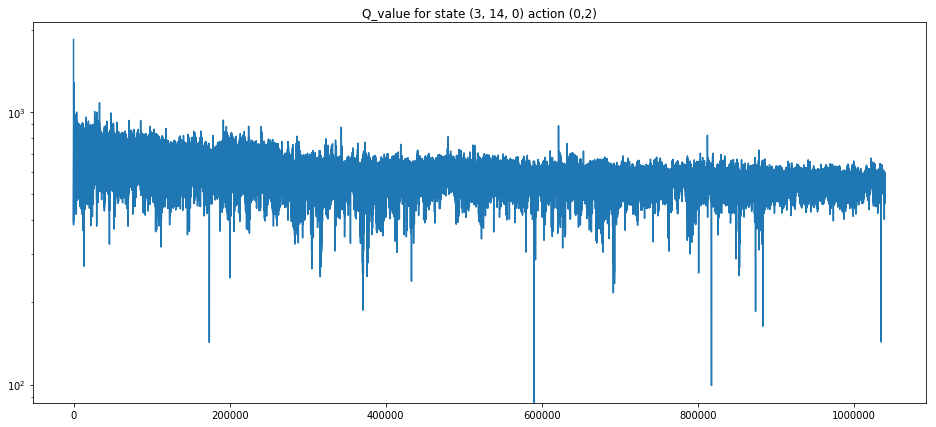

In [40]:
plt.figure(0, figsize=(16,7))
title = 'Q_value for state {} action (0,2)'.format(state)
plt.title(title)
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

In [41]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]


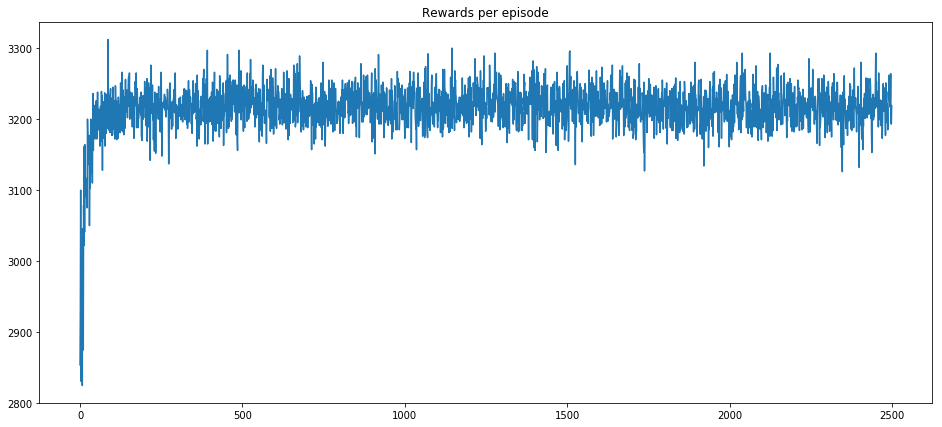

In [42]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [43]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

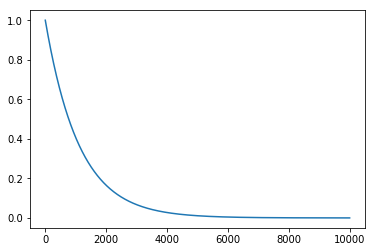

In [44]:
plt.plot(time, epsilon)
plt.show()